# plot_polynomial_interpolation

# [Polynomial and Spline interpolation — scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#sphx-glr-auto-examples-linear-model-plot-polynomial-interpolation-py)

In [1]:
%matplotlib inline

Duplicate key in file PosixPath('/Users/alphajay/.virtualenvs/ml/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 405 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


# Polynomial and Spline interpolation

This example demonstrates how to approximate a function with polynomials up to
degree ``degree`` by using ridge regression. We show two different ways given
``n_samples`` of 1d points ``x_i``:

- :class:`~sklearn.preprocessing.PolynomialFeatures` generates all monomials
  up to ``degree``. This gives us the so called Vandermonde matrix with
  ``n_samples`` rows and ``degree + 1`` columns::

    [[1, x_0, x_0 ** 2, x_0 ** 3, ..., x_0 ** degree],
     [1, x_1, x_1 ** 2, x_1 ** 3, ..., x_1 ** degree],
     ...]

  Intuitively, this matrix can be interpreted as a matrix of pseudo features
  (the points raised to some power). The matrix is akin to (but different from)
  the matrix induced by a polynomial kernel.

- :class:`~sklearn.preprocessing.SplineTransformer` generates B-spline basis
  functions. A basis function of a B-spline is a piece-wise polynomial function
  of degree ``degree`` that is non-zero only between ``degree+1`` consecutive
  knots. Given ``n_knots`` number of knots, this results in matrix of
  ``n_samples`` rows and ``n_knots + degree - 1`` columns::

    [[basis_1(x_0), basis_2(x_0), ...],
     [basis_1(x_1), basis_2(x_1), ...],
     ...]

This example shows that these two transformers are well suited to model
non-linear effects with a linear model, using a pipeline to add non-linear
features. Kernel methods extend this idea and can induce very high (even
infinite) dimensional feature spaces.


In [27]:
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline

We start by defining a function that we intend to approximate and prepare
plotting it.



In [37]:
def f(x):
    """Function to be approximated by polynomial interpolation."""
    return x * np.sin(x)


# whole range we want to plot
x_plot = np.linspace(-1, 11, 100)
#print(x_plot)

To make it interesting, we only give a small subset of points to train on.



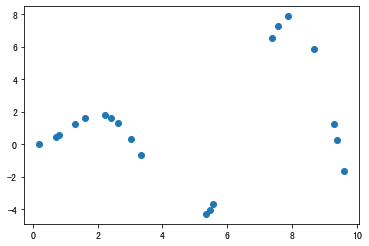

In [52]:
x_train = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=20, replace=False))
y_train = f(x_train)

# create 2D-array versions of these arrays to feed to transformers
X_train = x_train[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

plt.scatter(x_train, y_train)

Now we are ready to create polynomial features and splines, fit on the
training points and show how well they interpolate.



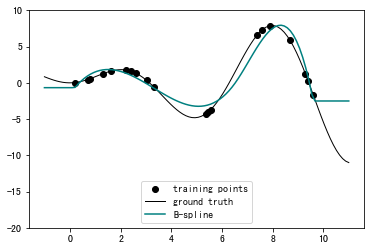

In [51]:
# plot function
lw = 1
fig, ax = plt.subplots()
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)
# plot training points
ax.scatter(x_train, y_train, label="training points")
ax.plot(x_plot, f(x_plot), linewidth=lw, label="ground truth")

# polynomial features
polynomialList = [2, 3, 4, 5, 6, 7]
polynomialList = []
for degree in polynomialList:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot = model.predict(X_plot)
    ax.plot(x_plot, y_plot, label=f"degree {degree}")

# B-spline with 4 + 3 - 1 = 6 basis functions
model = make_pipeline(SplineTransformer(n_knots=4, degree=3), Ridge(alpha=1e-3))
model.fit(X_train, y_train)

y_plot = model.predict(X_plot)
ax.plot(x_plot, y_plot, label="B-spline")


ax.legend(loc="lower center")
ax.set_ylim(-20, 10)
plt.show()

This shows nicely that higher degree polynomials can fit the data better. But
at the same time, too high powers can show unwanted oscillatory behaviour
and are particularly dangerous for extrapolation beyond the range of fitted
data. This is an advantage of B-splines. They usually fit the data as well as
polynomials and show very nice and smooth behaviour. They have also good
options to control the extrapolation, which defaults to continue with a
constant. Note that most often, you would rather increase the number of knots
but keep ``degree=3``.

In order to give more insights into the generated feature bases, we plot all
columns of both transformers separately.



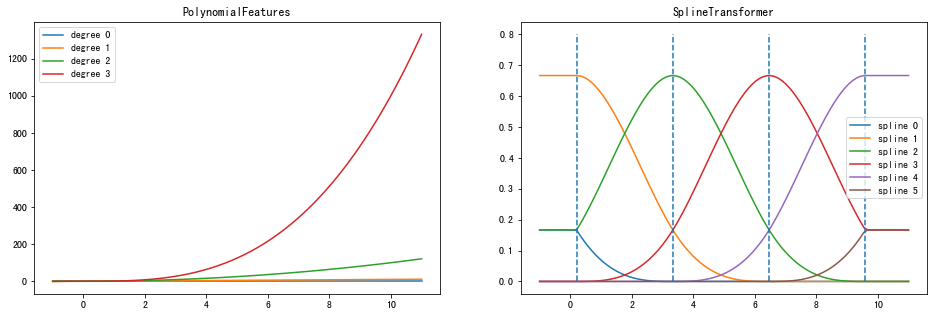

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
pft = PolynomialFeatures(degree=3).fit(X_train)
axes[0].plot(x_plot, pft.transform(X_plot))
axes[0].legend(axes[0].lines, [f"degree {n}" for n in range(4)])
axes[0].set_title("PolynomialFeatures")

splt = SplineTransformer(n_knots=4, degree=3).fit(X_train)
axes[1].plot(x_plot, splt.transform(X_plot))
axes[1].legend(axes[1].lines, [f"spline {n}" for n in range(6)])
axes[1].set_title("SplineTransformer")

# plot knots of spline
knots = splt.bsplines_[0].t
axes[1].vlines(knots[3:-3], ymin=0, ymax=0.8, linestyles="dashed")
plt.show()

In the left plot, we recognize the lines corresponding to simple monomials
from ``x**0`` to ``x**3``. In the right figure, we see the six B-spline
basis functions of ``degree=3`` and also the four knot positions that were
chosen during ``fit``. Note that there are ``degree`` number of additional
knots each to the left and to the right of the fitted interval. These are
there for technical reasons, so we refrain from showing them. Every basis
function has local support and is continued as a constant beyond the fitted
range. This extrapolating behaviour could be changed by the argument
``extrapolation``.



## Periodic Splines
In the previous example we saw the limitations of polynomials and splines for
extrapolation beyond the range of the training observations. In some
settings, e.g. with seasonal effects, we expect a periodic continuation of
the underlying signal. Such effects can be modelled using periodic splines,
which have equal function value and equal derivatives at the first and last
knot. In the following case we show how periodic splines provide a better fit
both within and outside of the range of training data given the additional
information of periodicity. The splines period is the distance between
the first and last knot, which we specify manually.

Periodic splines can also be useful for naturally periodic features (such as
day of the year), as the smoothness at the boundary knots prevents a jump in
the transformed values (e.g. from Dec 31st to Jan 1st). For such naturally
periodic features or more generally features where the period is known, it is
advised to explicitly pass this information to the `SplineTransformer` by
setting the knots manually.



/var/folders/3y/xjcv8dcs1rg57mpqc7fgllj80000gn/T/ipykernel_17614/3180212657.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


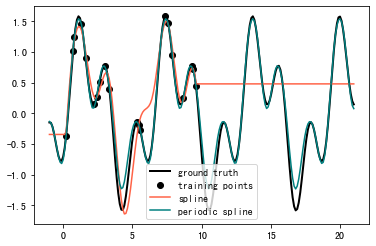

In [47]:
def g(x):
    """Function to be approximated by periodic spline interpolation."""
    return np.sin(x) - 0.7 * np.cos(x * 3)


y_train = g(x_train)

# Extend the test data into the future:
x_plot_ext = np.linspace(-1, 21, 200)
X_plot_ext = x_plot_ext[:, np.newaxis]

lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(color=["black", "tomato", "teal"])
ax.plot(x_plot_ext, g(x_plot_ext), linewidth=lw, label="ground truth")
ax.scatter(x_train, y_train, label="training points")

for transformer, label in [
    (SplineTransformer(degree=3, n_knots=10), "spline"),
    (
        SplineTransformer(
            degree=3,
            knots=np.linspace(0, 2 * np.pi, 10)[:, None],
            extrapolation="periodic",
        ),
        "periodic spline",
    ),
]:
    model = make_pipeline(transformer, Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot_ext = model.predict(X_plot_ext)
    ax.plot(x_plot_ext, y_plot_ext, label=label)

ax.legend()
fig.show()

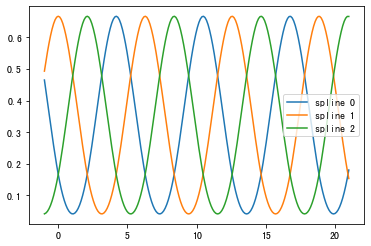

In [33]:
fig, ax = plt.subplots()
knots = np.linspace(0, 2 * np.pi, 4)
splt = SplineTransformer(knots=knots[:, None], degree=3, extrapolation="periodic").fit(
    X_train
)
ax.plot(x_plot_ext, splt.transform(X_plot_ext))
ax.legend(ax.lines, [f"spline {n}" for n in range(3)])
plt.show()